In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import xgboost as xgb


In [2]:
df = pd.read_csv("Winequality-red.csv", sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.shape

(1599, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [7]:
df.duplicated().sum()  # checks for duplicate values


np.int64(240)

In [8]:
df = df.drop_duplicates()  # we drop the duplicate values
df.shape

(1359, 12)

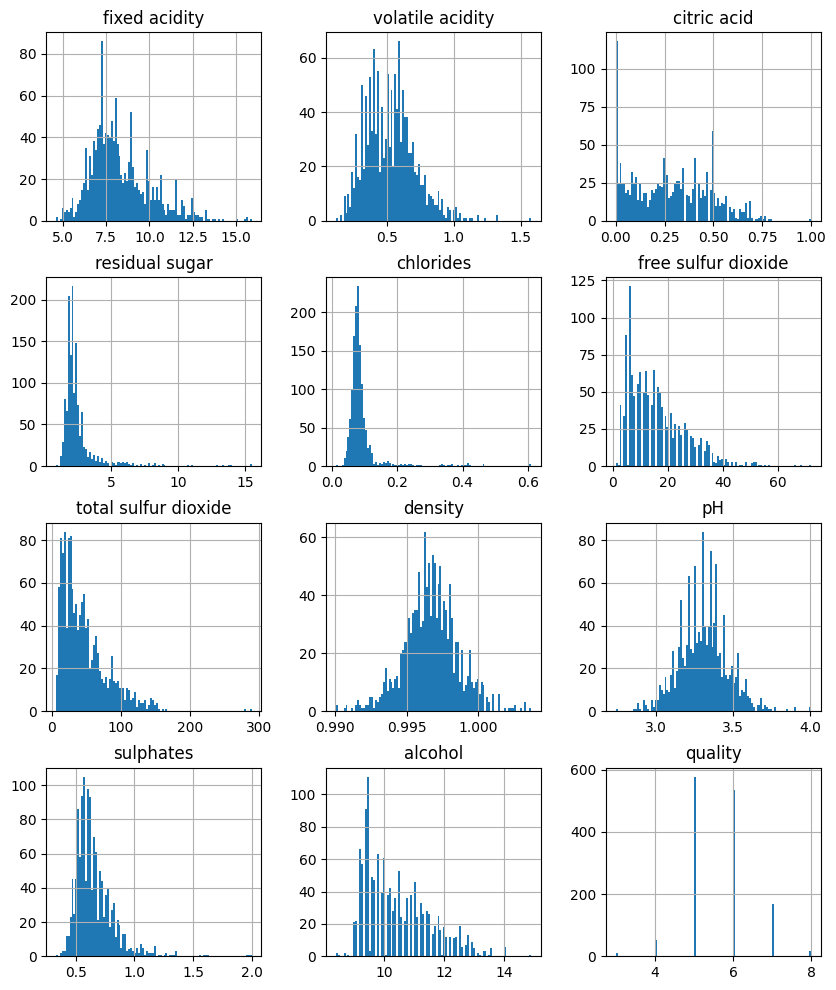

In [9]:
df.hist(bins=100, figsize=(10,12))
plt.show()

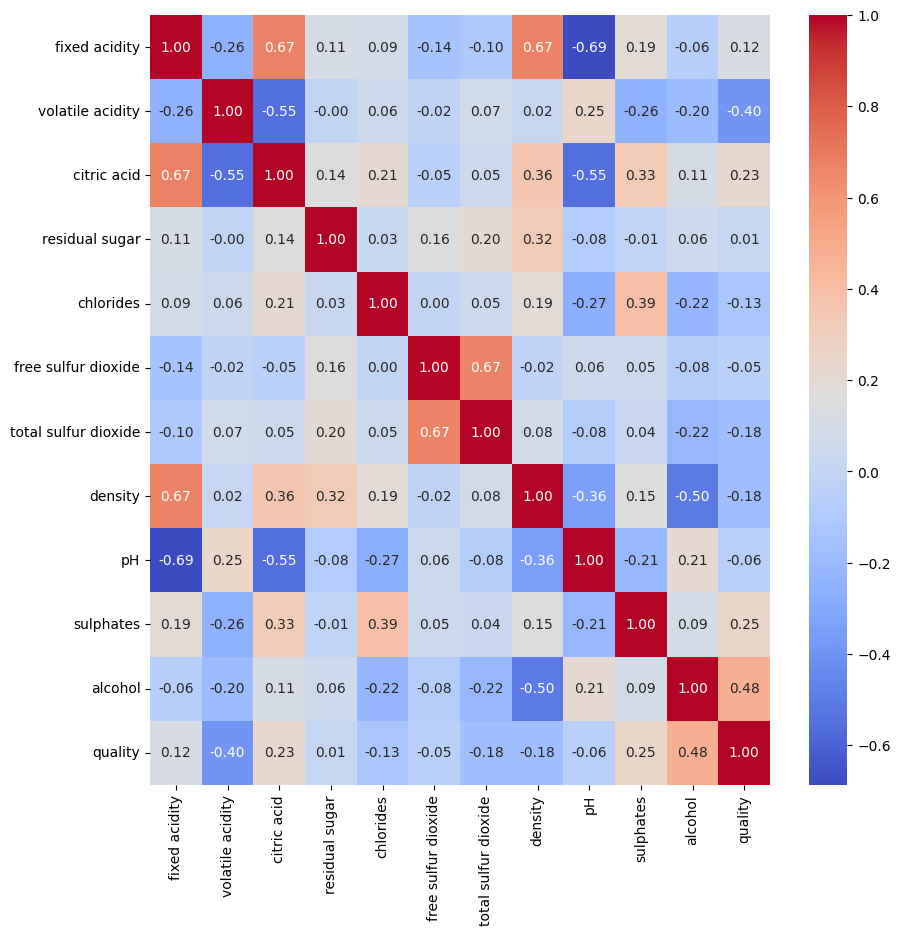

In [10]:
plt.figure(figsize=(10,10))
correlation_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [11]:
# Now we make a dataframe for all the predictor variables
X = df[['fixed acidity', 'citric acid', 'density', 'quality']]
X.head()

,fixed acidity,citric acid,density,quality
0,7.4,0.00,0.9978,5
1,7.8,0.00,0.9968,5
2,7.8,0.04,0.9970,5
3,11.2,0.56,0.9980,6
5,7.4,0.00,0.9978,5


C:\Users\adity\AppData\Local\Temp\ipykernel_10148\2023287464.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='Set1')


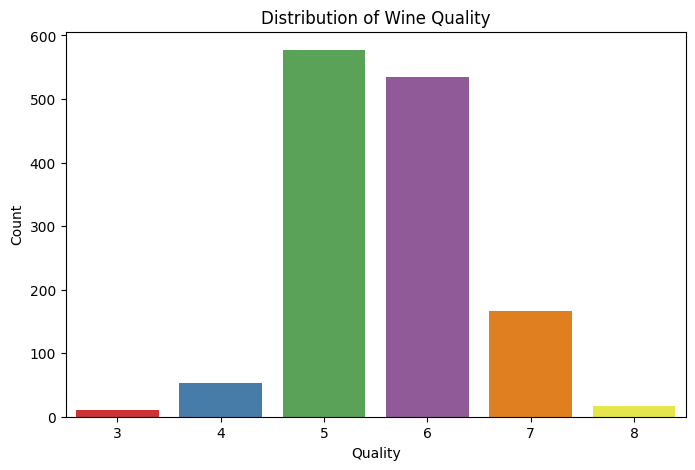

In [12]:
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=df, palette='Set1')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()


In [13]:
# Step 5: Feature and target selection
X = df.drop(columns=['quality'])  # Feature variables
y = df['quality']  # Target variable

In [14]:
# Step 6: Convert quality into binary classification (good vs bad)
y = y.apply(lambda q: 1 if q >= 6 else 0)  # 1: Good quality, 0: Bad quality

In [15]:
# Step 8: Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Step 9: Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Step 10: Model Training with different classifiers
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}


Training RandomForest Model...
RandomForest Accuracy: 0.7684, F1 Score: 0.7742, AUC Score: 0.8388
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       128
           1       0.80      0.75      0.77       144

    accuracy                           0.77       272
   macro avg       0.77      0.77      0.77       272
weighted avg       0.77      0.77      0.77       272



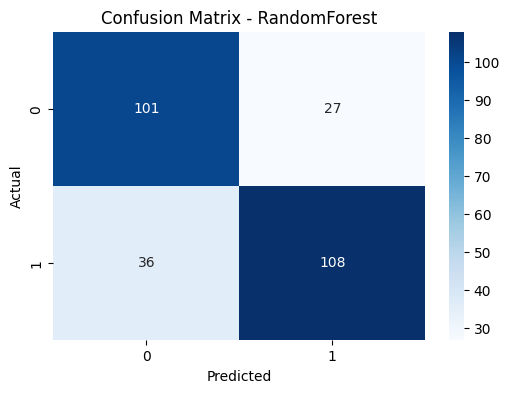


Training SVM Model...
SVM Accuracy: 0.7537, F1 Score: 0.7616, AUC Score: 0.8234
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       128
           1       0.78      0.74      0.76       144

    accuracy                           0.75       272
   macro avg       0.75      0.75      0.75       272
weighted avg       0.76      0.75      0.75       272



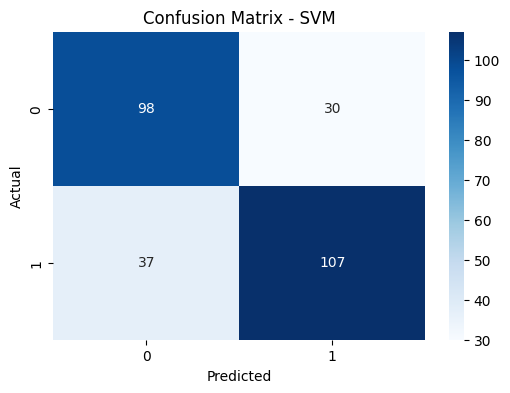


Training XGBoost Model...


C:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7610, F1 Score: 0.7703, AUC Score: 0.8055
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       128
           1       0.78      0.76      0.77       144

    accuracy                           0.76       272
   macro avg       0.76      0.76      0.76       272
weighted avg       0.76      0.76      0.76       272



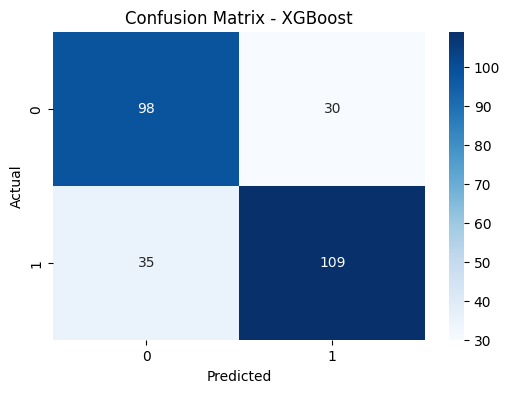


Training GradientBoosting Model...
GradientBoosting Accuracy: 0.7610, F1 Score: 0.7719, AUC Score: 0.8275
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       128
           1       0.78      0.76      0.77       144

    accuracy                           0.76       272
   macro avg       0.76      0.76      0.76       272
weighted avg       0.76      0.76      0.76       272



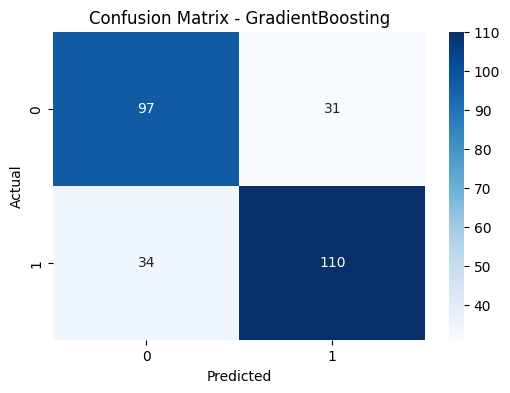

In [18]:
for name, model in models.items():
    print(f"\nTraining {name} Model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"{name} Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, AUC Score: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [19]:
# Hyperparameter tuning for best model (for RandomForest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Parameters for RandomForest:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Final Accuracy after hyperparameter tuning:", accuracy_score(y_test, y_pred_best))


Best Parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Final Accuracy after hyperparameter tuning: 0.7536764705882353


In [20]:
# Cross-Validation Score
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")


Cross-Validation Accuracy Scores: [0.6875     0.72058824 0.79044118 0.71323529 0.75645756]
Mean CV Accuracy: 0.7336


C:\Users\adity\AppData\Local\Temp\ipykernel_10148\1912409113.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')


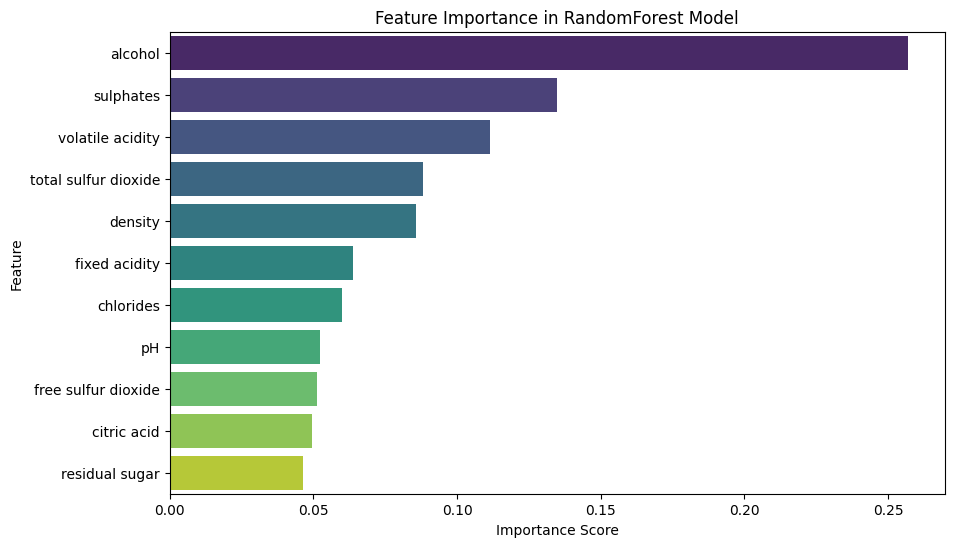

In [21]:
# Step 14: Feature Importance Analysis
feature_importances = best_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')
plt.title("Feature Importance in RandomForest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


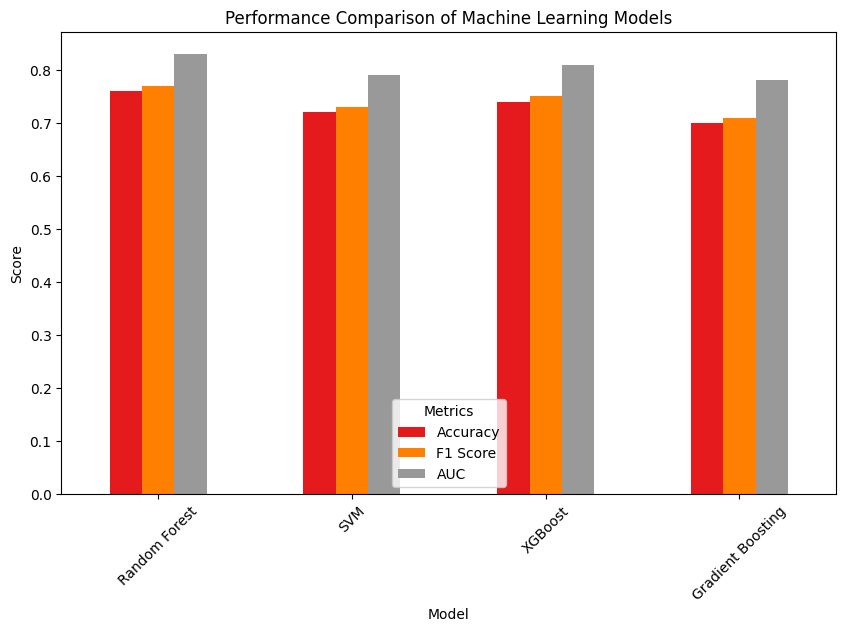

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Example performance metrics for each model
performance_data = {
    'Model': ['Random Forest', 'SVM', 'XGBoost', 'Gradient Boosting'],
    'Accuracy': [0.76, 0.72, 0.74, 0.70],
    'F1 Score': [0.77, 0.73, 0.75, 0.71],
    'AUC': [0.83, 0.79, 0.81, 0.78]
}
df_performance = pd.DataFrame(performance_data)

df_performance.set_index('Model').plot(kind='bar', figsize=(10, 6), colormap='Set1')
plt.title('Performance Comparison of Machine Learning Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

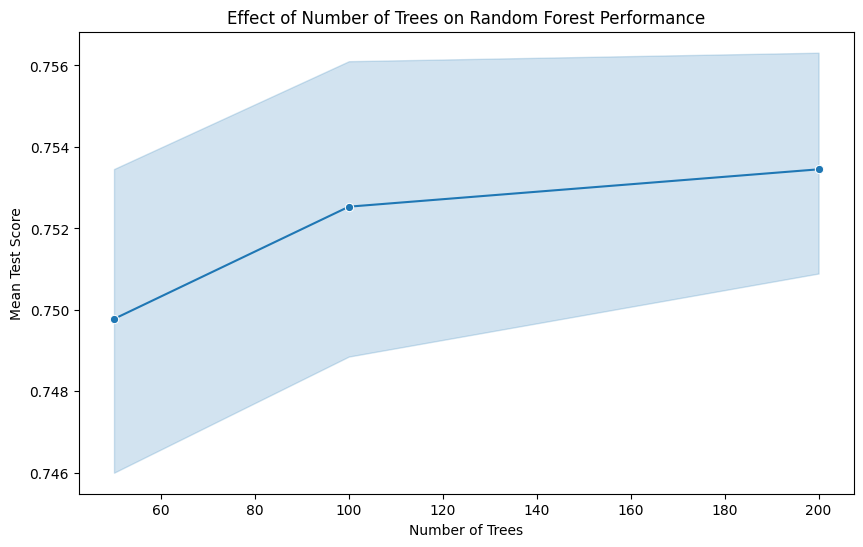

In [23]:
import pandas as pd
import seaborn as sns

# Example results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.title('Effect of Number of Trees on Random Forest Performance')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Test Score')
plt.show()